In [ ]:
import os
workplace = 'ML/data'
try:
    os.chdir(os.path.join('/content/drive/MyDrive', workplace))
except:
    os.mkdir(os.path.join('/content/drive/MyDrive', workplace))
    os.chdir(os.path.join('/content/drive/MyDrive', workplace))

## Import Package

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import type_of_target
import treePlottter # 下载地址：https://github.com/Humble-LiuAo/Machine-Learning/tree/main/Decision%20Tree
from sklearn.datasets import load_wine
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import random
from collections import Counter
from statistics import mode

## Read dataset

In [ ]:
# load wine 数据集
data_wine = load_wine()
target = data_wine['target']        
data = data_wine['data']
feature_names = data_wine['feature_names']
target_names  = data_wine['target_names']

# X：数据 y：标签（种类）
X = pd.DataFrame(data,columns=feature_names)
y = pd.Series(target,name='class')
# 训练集、验证集分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=422)

## CART

In [ ]:
class Node(object):
    '''
    树的结点
    例：分割值、属性（是否连续）、是否是叶结点
    '''
    def __init__(self):
        self.feature_name = None
        self.feature_index = None
        self.subtree = {}
        self.impurity = None
        self.is_continuous = True
        self.split_value = None
        self.is_leaf = False
        self.leaf_class = None
        self.leaf_num = None
        self.high = -1


class DecisionTree(object):
    '''
    CART 决策树
    包含对离散、连续属性的处理
    包含随机森林随机选取属性
    无剪枝，无对缺失值的处理
    '''
    def __init__(self, random_forest=False):
        self.col_name = []
        self.random_forest = random_forest

    def fit(self, X_train, y_train):
        '''
        生成决策树
        -------
        :param X:  只支持DataFrame类型数据，因为DataFrame中已有列名，省去一个列名的参数。不支持np.array等其他数据类型
        :param y:
        :return:
        '''
        X_train.reset_index(inplace=True, drop=True)
        y_train.reset_index(inplace=True, drop=True)
        
        self.columns = list(X_train.columns)  # 包括原数据的列名
        self.tree_ = self.generate_tree(X_train, y_train)
        return self

    def generate_tree(self, X, y):
        my_tree = Node()
        my_tree.leaf_num = 0

        if y.nunique() == 1:  # 属于同一类别
            my_tree.is_leaf = True
            my_tree.leaf_class = y.values[0]
            my_tree.high = 0
            my_tree.leaf_num += 1
            return my_tree

        if X.empty:  # 特征用完了，数据为空，返回样本数最多的类
            my_tree.is_leaf = True
            my_tree.leaf_class = pd.value_counts(y).index[0]
            my_tree.high = 0
            my_tree.leaf_num += 1
            return my_tree

        best_feature_name, best_impurity = self.choose_best_feature_gini(X, y)

        my_tree.feature_name = best_feature_name
        my_tree.impurity = best_impurity[0]
        my_tree.feature_index = self.columns.index(best_feature_name)

        feature_values = X.loc[:, best_feature_name]

        if len(best_impurity) == 1:  # 离散值
            my_tree.is_continuous = False

            unique_vals = pd.unique(feature_values)
            sub_X = X.drop(best_feature_name, axis=1)

            max_high = -1
            for value in unique_vals:
                my_tree.subtree[value] = self.generate_tree(sub_X[feature_values == value], y[feature_values == value])
                if my_tree.subtree[value].high > max_high:  # 记录子树下最高的高度
                    max_high = my_tree.subtree[value].high
                my_tree.leaf_num += my_tree.subtree[value].leaf_num

            my_tree.high = max_high + 1

        elif len(best_impurity) == 2:  # 连续值
            my_tree.is_continuous = True
            my_tree.split_value = best_impurity[1]
            up_part = '>= {:.3f}'.format(my_tree.split_value)
            down_part = '< {:.3f}'.format(my_tree.split_value)

            my_tree.subtree[up_part] = self.generate_tree(X[feature_values >= my_tree.split_value],
                                                          y[feature_values >= my_tree.split_value])
            my_tree.subtree[down_part] = self.generate_tree(X[feature_values < my_tree.split_value],
                                                            y[feature_values < my_tree.split_value])

            my_tree.leaf_num += (my_tree.subtree[up_part].leaf_num + my_tree.subtree[down_part].leaf_num)

            my_tree.high = max(my_tree.subtree[up_part].high, my_tree.subtree[down_part].high) + 1

        return my_tree

    def predict(self, X):
        '''
        同样只支持 pd.DataFrame类型数据
        :param X:  pd.DataFrame 类型
        :return:   若
        '''
        if not hasattr(self, "tree_"):
            raise Exception('you have to fit first before predict.')
        if X.ndim == 1:
            return self.predict_single(X)
        else:
            return X.apply(self.predict_single, axis=1)

    def predict_single(self, x, subtree=None):
        '''
        预测单一样本。 实际上这里也可以写成循环，写成递归样本大的时候有栈溢出的风险。
        :param x:
        :param subtree: 根据特征，往下递进的子树。
        :return:
        '''
        if subtree is None:
            subtree = self.tree_

        if subtree.is_leaf:
            return subtree.leaf_class

        if subtree.is_continuous:  # 若是连续值，需要判断是
            if x[subtree.feature_index] >= subtree.split_value:
                return self.predict_single(x, subtree.subtree['>= {:.3f}'.format(subtree.split_value)])
            else:
                return self.predict_single(x, subtree.subtree['< {:.3f}'.format(subtree.split_value)])
        else:
            return self.predict_single(x, subtree.subtree[x[subtree.feature_index]])

    def choose_best_feature_gini(self, X, y):
        '''
        选择划分最优属性
        随机森林选随机选取np.log2(X.shape[1])个属性
        '''
        features = X.columns
        if self.random_forest: # 随机选取属性 
            col = random.sample(range(0, X.shape[1]), round(np.log2(X.shape[1]))) 
            features = features[col]

        best_feature_name = None
        best_gini = [float('inf')]
        for feature_name in features:
            # is_continuous = type_of_target(X[feature_name]) == 'continuous'
            is_continuous = 'continuous' # wine 数据集全为连续
            gini_idex = self.gini_index(X[feature_name], y, is_continuous)
            if gini_idex[0] < best_gini[0]:
                best_feature_name = feature_name
                best_gini = gini_idex

        return best_feature_name, best_gini

    def gini_index(self, feature, y, is_continuous=False):
        '''
        计算基尼指数， 对于连续值，选择基尼指数最小的点，作为分割点
        -------
        :param feature:
        :param y:
        :return:
        '''
        m = y.shape[0]
        unique_value = pd.unique(feature)
        if is_continuous:
            unique_value.sort()  # 排序, 用于建立分割点
            # 这里其实也可以直接用feature值作为分割点，但这样会出现空集
            split_point_set = [(unique_value[i] + unique_value[i + 1]) / 2 for i in range(len(unique_value) - 1)]

            min_gini = float('inf')
            min_gini_point = None
            for split_point_ in split_point_set:  # 遍历所有的分割点，寻找基尼指数最小的分割点
                Dv1 = y[feature <= split_point_]
                Dv2 = y[feature > split_point_]
                gini_index = Dv1.shape[0] / m * self.gini(Dv1) + Dv2.shape[0] / m * self.gini(Dv2)

                if gini_index < min_gini:
                    min_gini = gini_index
                    min_gini_point = split_point_
            return [min_gini, min_gini_point]
        else:
            gini_index = 0
            for value in unique_value:
                Dv = y[feature == value]
                m_dv = Dv.shape[0]
                gini = self.gini(Dv)  
                gini_index += m_dv / m * gini  

            return [gini_index]

    def gini(self, y):
        p = pd.value_counts(y) / y.shape[0]
        gini = 1 - np.sum(p ** 2)
        return gini


# Ramdom forests

In [ ]:
class random_forest():
    '''
    CART 随机森林
    ---
    随机选取样本 
    随机选取特征(CART: choose_best_feature_gini() 函数中)
    '''
    def __init__(self, num_trees, samples=100): # samples默认100
        self.samples = samples
        self.forest = []
        self.num_trees = num_trees

    def fit(self, X_train, y_train):
        '''
        训练 num_trees 棵树
        '''    
        for i in range(self.num_trees):
            bootstrapSamples = resample(X_train,y_train,n_samples=self.samples,replace=True) # 随机选取部分样本
            X__train, y__train = bootstrapSamples[0], bootstrapSamples[1]
            tree = DecisionTree(random_forest=True)
            tree.fit(X__train, y__train)
            # treePlottter.create_plot(tree.tree_)
                     
            self.forest.append(tree)

    def predict(self, X_val):
        '''
        num_trees 分别棵树进行预测
        多数投票法得到最终预测
        '''
        predict = []
        final_pred = np.array([])

        for tree in self.forest:
            y = tree.predict(X_val)
            predict.append(y)
            tree_accuracy = (y==y_val).sum()/len(y_val)
            print(f"tree_accuracy: {tree_accuracy*100}%")

        for index, v in X_val.iterrows():
            li = []
            for i in range(self.num_trees):
                li.append(predict[i][index])
            try:
                value = mode(li) # 多个值相同最多次数时： no unique mode
            except:
                value = Counter(li) # 次数最多的值，如果有多个值，随机选取其中一个
                value = value.most_common(1)[0][0]
                print(value)
            final_pred = np.append(final_pred, value)
        return final_pred
        

## Main

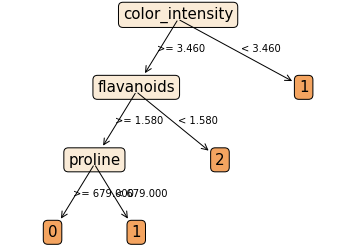

In [ ]:
# decision tree
one_tree = DecisionTree()
one_tree.fit(X_train, y_train)
treePlottter.create_plot(one_tree.tree_)

In [ ]:
# random forest
num_trees = 20
random_forest = random_forest(num_trees)
random_forest.fit(X_train, y_train)

## Test

In [ ]:
pre = random_forest.predict(X_val)
tree_accuracy = (one_tree.predict(X_val)==y_val).sum()/len(y_val)
forest_accuracy = (pre==y_val).sum()/len(y_val)
print(f"tree_accuracy: {tree_accuracy*100}%,forest_accuracy: {forest_accuracy*100}%")

tree_accuracy: 87.03703703703704%
tree_accuracy: 87.03703703703704%
tree_accuracy: 87.03703703703704%
tree_accuracy: 75.92592592592592%
tree_accuracy: 85.18518518518519%
tree_accuracy: 88.88888888888889%
tree_accuracy: 87.03703703703704%
tree_accuracy: 92.5925925925926%
tree_accuracy: 94.44444444444444%
tree_accuracy: 85.18518518518519%
tree_accuracy: 87.03703703703704%
tree_accuracy: 92.5925925925926%
tree_accuracy: 79.62962962962963%
tree_accuracy: 85.18518518518519%
tree_accuracy: 85.18518518518519%
tree_accuracy: 92.5925925925926%,forest_accuracy: 98.14814814814815%
